# Image Classifcation Web App  using Flask and fastai

One of the things I find really difficult when finishing a Data Science or Machine Learning project is that I don't really have a feeling of completeness. We have a great performing model, but what to do now? We can make interacting with our trained model more enjoyable. Therefore, today we are going to build a really simple web app to deploy a trained deep learning image classifier. This application allows the user to submit their own image and get a classification label back.

In our particular case, we build a web application that can classify an image of a fashion item into one of the 100+ clothing categories! We'll build and train a Convolutional Neural Network (CNN) using <a href="https://www.fast.ai" target="_blank">fastai</a> to recognize fashion items on images. After training our model, we build a super simple web application using Flask to make inferences/predictions on our own images.

To train our fashion item classifier we need alot of images of clothing items. The <a href="https://www.kaggle.com/paramaggarwal/fashion-product-images-small" target="_blank">Fashion Product Images (Small)</a> dataset on <a href="https://www.kaggle.com" target="_blank">Kaggle</a> provides enough images to train a descent image classifier.

After some CSS styling, the final web app looks something like this:

The web app looks like this:

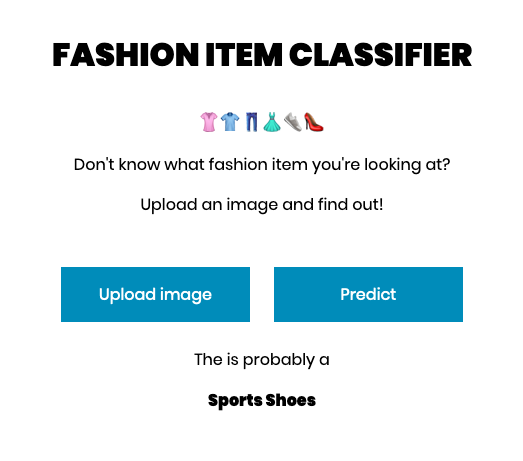

## Image Classification Model

I use the <a href="https://docs.fast.ai" target="_blank">fastai</a> framework to train an image classifier. This framework provides a really easy and intuitive way for training state of the art deep learning models. Founder, <a href="https://twitter.com/jeremyphoward" target="_blank">Jeremy Howard</a>, teaches an excellent <a href="https://course.fast.ai/" target="_blank">course</a> in deep learning for free using the fastai framework. I can't recommend this course enough! 

Let's get started!

In [1]:
import glob
import pandas as pd

from fastai import *
from fastai.vision import *

### Loading the data

First, we need to provide a path to the folder containing the images. I've put the image folder in the same folder as my notebook. We use `glob` package to get the paths for all the images stored in a list.

After this, we extract the file names using a list comprehension. I use the image names to select the target labels in the CSV.  Not all labels have a corresponding image. 

We split the paths on `/` and select the last item (filename + extension). These image file names correspond to the id column in the CSV. We also split on `.` because I want only the file name, not the file extension. 

In [2]:
path = Path("images")

files = sorted(glob.glob("images/*"))
files_names = [int(file.split('/')[-1].split(".")[0]) for file in files]
files_names[:5]

[10000, 10001, 10002, 10003, 10004]

We now read in the *styles.csv* file containing the labels/classes for the images. I select the `id` column for the data frame that corresponds to the image names. We also select the `articleType` column containing the image class. 

We only selected the rows in our data frame that have a corresponding image file using `isin()`. I also chose to disregard rare labels (less than 10). Keeping these labels can impact performance negatively and sometimes leads to issues when using cross-validation.

In [3]:
df = pd.read_csv("styles.csv", usecols=["id", "articleType"])
df_full = df[df.id.isin(files_names)]
df_train = df_full.groupby('articleType').filter(lambda x: len(x) > 10)

We now have a data frame that contains the id of the images and their corresponding target labels.

### Creating the dataset

We are now ready to create a dataset. The fastai framework uses this dataset to train our image classifier. The process of creating a dataset for the framework is pretty easy and encompasses 4 steps:

1. Provide the inputs
2. Split the data 
3. Label the inputs + transformations
4. Convert to databunch

As stated earlier, I highly recommend following the fastai course to get a better understanding of the framework.

In [4]:
data = (ImageList
        # 1. Provide the inputs
         .from_df(df_train, path=path/"images", suffix=".jpg")
        
        # 2. Split the data
         .split_by_rand_pct(0.2)
        
        # 3. Label the inputs + transformations
         .label_from_df()
         .transform(get_transforms(), size=60)
        
        # 4. Convert to databunch
         .databunch(bs=256))

As the cell above displays, we (1) provide a path to our images and labels. After this, we (2) split the data in 80% train and 20% validation data. Subsequently, we get the (3) label from the data frame, apply image augmentations using get_transforms(). We also resize our images to 60x60 pixels. Lastly, we (4) create databunch with a batch size of 256.

In [5]:
data.c, len(data.train_ds), len(data.valid_ds)

(107, 35430, 8857)

The dataset contains 107 different classes,  with 35430 training images and 8857 validation images.

### Visualizing the data

Before training our model on this dataset, it's always a good idea to plot the images and their corresponding labels. Visualizing the data allows us to inspect if our dataset creation was successful. Do the images have the right labels?

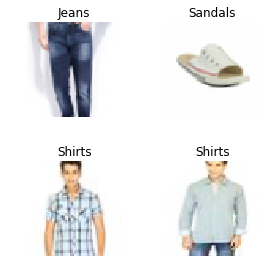

In [6]:
data.show_batch(2, figsize=(4, 4))

Everything seems to be working out nicely!

### Training the model

The training time is here! But we first need to decide which pre-trained model to use. We'll use transfer learning to train the last few layers of this CNN to make it fit our specific problem.

I chose ResNet50 architecture because it's pretty <a href="https://dawn.cs.stanford.edu/benchmark/" target="_blank">successful</a> at image classification! We use accuracy as our training metric, because this is the metric we're most interested in.

In [7]:
learn = cnn_learner(data, models.resnet50 ,metrics=accuracy);

One of the most important but also one of the hardest parts is choosing a proper learning rate. I use fastai's learning rate finder capability to choose the learning rate to keep it simple. However, for a better understanding of how to choose a learning rate, follow the fastai course.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-03
Min loss divided by 10: 3.02E-02


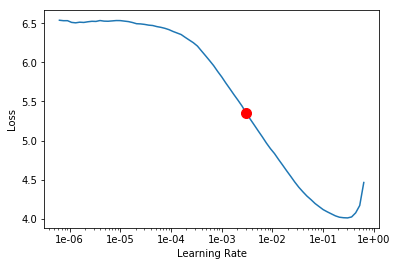

In [8]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

Our model doesn't need to train for many epochs for us to asses its performance. We train our model for 6 epochs using the suggested learning rate. It's performing okay. Make sure to also save this trained model, we don't want to lose it!

In [9]:
lr = 3.02E-03
learn.fit_one_cycle(6, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,2.264242,1.361210,0.643446,02:03
1,1.436984,1.009337,0.704076,01:28
2,1.127053,0.857740,0.742012,01:25
3,0.968476,0.787414,0.756125,01:26
4,0.846337,0.730250,0.774867,01:24
5,0.799669,0.725658,0.776448,01:24


In [11]:
learn.save("stage-1")

Let's try to improve this model. By unfreezing, we can train the full model, not only the last layers.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 2.29E-05


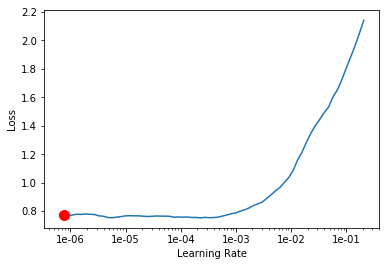

In [12]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

We now train the unfrozen model for 6 more epochs, 12 epochs in total. Also, make sure to save the second training stage of our model.

In [13]:
learn.fit_one_cycle(6, slice(1e-04, lr/5))
learn.save("stage-2")

epoch,train_loss,valid_loss,accuracy,time
0,0.722455,0.669436,0.792368,01:25
1,0.665747,0.577647,0.820820,01:26
2,0.563481,0.532775,0.837530,01:24
3,0.459141,0.457600,0.859998,01:25
4,0.365240,0.431368,0.866208,01:24
5,0.304618,0.419512,0.870498,01:24


We reach an accuracy score of about 87% percent with 107 classes. This is a good enough model to use in our web app! Let's export this model so we can use it in our application.

In [18]:
learn.export()

## Building an Image Classification Web App

Now that we trained our model, and it performs well enough (we can always do better), we are ready to build a web app. This application is build using only Python and HTML (additionally some CSS for styling). This web server will be build using Flask. This (micro) framework allows us to write a web app in Python. 

The file structure of our app will be as follows:

```
.
├── app.py
├── models
│   └── fashion-classifier.pkl
├── static
│   └── style.css
└── templates
    └── index.html
```

Make sure to put the exported model into the `models` folder. The *style.css* style sheet is in the `static` folder, the *index.html* is in the `templates` folder.

### A simple web-server

We'll start by building a very simple web-server using Flask. We can create a basic web-server using the code below.

```python
from flask import Flask

app = Flask(__name__)

@app.route("/")
def predict():
    return "Hello World!"
```

So what does this code actually do? Let me explain: The following code lets us create a new Flask app by:

```python
app = Flask(__name__)
```

Above our predict function, we see a decorator. This decorator is telling our app, whenever someone uses our app domain at the given route, execute the predict function below it. In this case, it will return the "Hello World" string.

```python
@app.route("/")
```

We can now run our web-server and run it in debug mode, which allows us to automatically reload the server. To start the web-server and run it in debug mode:

```shell
$ export FLASK_APP=app.py
$ export FLASK_DEBUG=1
$ flask run
```

This will provide us with a web-server at http://localhost:5000/ (default).

### The prediction API

We now build on the previous code to create our prediction API. This API needs to accept an image from a user as in input. Use this image to predict a fashion item class and return this class to a web-page. The code in the `app.py` for our predict API looks like the following:

```python
from fastai.vision import load_learner, open_image
from flask import Flask, render_template, request

clf = load_learner("model", "fashion-classifier.pkl")
app = Flask(__name__)

@app.route('/', methods=['GET', 'POST'])
def get_prediction():
    if request.method == 'POST':
        image_file = request.files['image-file']
        image = open_image(image_file)
        pred = clf.predict(image)[0]
        return render_template('home.html', label=pred)
    else: 
        return render_template('home.html')
```

Let's run through this code line by line. First, we used `load_learner` to load our trained model stored as a pickle file.

```python
clf = load_learner("model", "fashion-classifier.pkl")
```

After loading the model, we need a way to make "POST" and "GET" requests.

```python
@app.route('/', methods=['GET', 'POST'])
def get_prediction():
```

Inside our predict function, we check if we're making a POST request. In our case, this is "uploading" an image.

```python
if request.method == 'POST':
```

If this is the case, we want to request the files with the name `image-file`.

```python
image_file = request.files['image-file']
```

We now use open_image from fastai to open this file as an image/array.

```python
image = open_image(image_file)
```

After opening up this image, we can use our trained model to predict its class. Because `.predict` returns more than the class, we use index 0 to only grab the label. You could also grab the probability of the class if you wanted to.

```python
pred = clf.predict(image)[0]
```

We then use `render_template` to return the *index.html* page we will create in the next section.  However, we also add the label variable, which contains our prediction class. This variable can be displayed on the web page.

```python
return render_template('home.html', label=pred)
```

However, if we make a "GET" request, we simply want to render the original web page without adding the label variable.

```python
else: 
    return render_template('home.html')
```

The prediction API is now finished. Let's now build a simple HTML page for the user to interact with.

### Building the front-end

Now that our prediction Flask API is ready we can build the front-end for the user to interact with. We can start by building a basic HTML web-page with a form that can take an image as input.

This is how the body of our *index.html* file inside the templates folder looks like

```html
<body>
    <h1>Fasion item Classifier< /h1>
    <form method="post" enctype=multipart/form-data>
        <input type="file" name="image-file"/>
        <input type="submit" value="predict"/>
    < /form>
    {% if label %}
        <p> {{ label }}< /p>
    {% endif %}
  < /body>
```

The `form` element is the main part of this page and is used to make "POST" requests. Make sure to set `enctype` to `multipart/form-data` as this is needed to accept files. The form takes two user inputs. The first one allows us to input a file/image. The second input submits the image and returns a prediction.

If an image file is uploaded and submitted,  we want to display the prediction result on the page. The HTML code below makes this possible.

```html
{% if prediction %}
  <p> {{ prediction }}< /p>
{% endif %} 
```

### Making inferences

We're now ready to upload our own image and see what our models predict this clothing item is. I will test our app by uploading this photo of my sneakers.

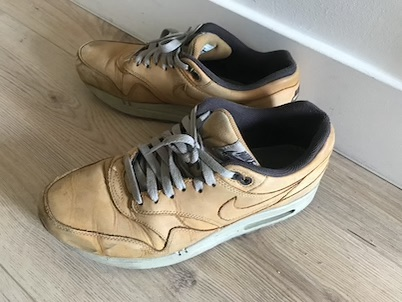

Let's make a prediction using our web app. The model predicts that these are "sports shoes", which is correct. The image below shows our web app without any additional styling.

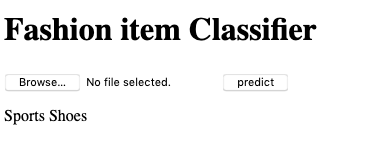

We now have a fully functional web app that can predict fashion items from an image. To make the app look like the example at the start of the post, you need to add some additional HTML and some CSS.

*The full web app with the additional HTML and CSS can be found on my <a href="https://github.com/maxscheijen/blog-post-code/tree/master/image-classification-web-app-using-fastai" target="_target">GitHub</a>.*